In [1]:
# Install imblearn if missing (Colab)
try:
    import imblearn
except Exception:
    !pip install -q imbalanced-learn

# ======================
# IMPORTS
# ======================
import os
import joblib
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE

In [2]:
# ======================
# 1) LOAD RAW CSVs (update paths if needed)
# ======================
train_df = pd.read_csv("train.csv")                         # labeled
campaign_df = pd.read_csv("campaign_data.csv")
coupon_item_mapping = pd.read_csv("coupon_item_mapping.csv")
item_data = pd.read_csv("item_data.csv")
cust_demo = pd.read_csv("customer_demographics.csv")
cust_trans = pd.read_csv("customer_transaction_data.csv")
test_df = pd.read_csv("test.csv")                           # unlabeled

print("Files loaded.")

Files loaded.


In [ ]:
# ======================
# 2) CLEAN & FEATURE ENGINEER (campaign, coupon, customer, transactions)
# ======================

In [5]:
import pandas as pd

# List of all raw CSV files you plan to use
csv_files = [
    "train.csv",
    "test.csv",
    "campaign_data.csv",
    "coupon_item_mapping.csv",
    "item_data.csv",
    "customer_demographics.csv",
    "customer_transaction_data.csv"
]

for file in csv_files:
    print(f"\nChecking {file} ...")
    try:
        df = pd.read_csv(file)
        print("Shape:", df.shape)

        # Null value check
        null_counts = df.isnull().sum()
        print("Null values per column:\n", null_counts[null_counts > 0])

        # Data types
        print("Data types:\n", df.dtypes)

        # Duplicates
        dup_count = df.duplicated().sum()
        print("Number of duplicate rows:", dup_count)

        # If label column exists, show value counts
        if 'redemption_status' in df.columns:
            print("Value counts for redemption_status:\n", df['redemption_status'].value_counts())

        # Show a sample of the data
        print("Sample rows:\n", df.head(3))
        print("---------------------------------------------------------------------------------------------------------------------------------")
    except Exception as e:
        print(f"Error reading {file}: {e}")


Checking train.csv ...
Shape: (78369, 5)
Null values per column:
 Series([], dtype: int64)
Data types:
 id                   int64
campaign_id          int64
coupon_id            int64
customer_id          int64
redemption_status    int64
dtype: object
Number of duplicate rows: 0
Value counts for redemption_status:
 redemption_status
0    77640
1      729
Name: count, dtype: int64
Sample rows:
    id  campaign_id  coupon_id  customer_id  redemption_status
0   1           13         27         1053                  0
1   2           13        116           48                  0
2   6            9        635          205                  0
---------------------------------------------------------------------------------------------------------------------------------

Checking test.csv ...
Shape: (50226, 4)
Null values per column:
 Series([], dtype: int64)
Data types:
 id             int64
campaign_id    int64
coupon_id      int64
customer_id    int64
dtype: object
Number of duplicate r

In [6]:
# Campaign: parse and duration
campaign_df = campaign_df.copy()
campaign_df['start_date'] = pd.to_datetime(campaign_df['start_date'], format="%d/%m/%y", errors='coerce')
campaign_df['end_date']   = pd.to_datetime(campaign_df['end_date'],   format="%d/%m/%y", errors='coerce')
campaign_df['campaign_duration'] = (campaign_df['end_date'] - campaign_df['start_date']).dt.days


In [7]:
# Coupon-item aggregates (coupon-level features)
coupon_item_merged = coupon_item_mapping.merge(item_data, on='item_id', how='left')
coupon_item_features = coupon_item_merged.groupby('coupon_id').agg(
    num_unique_items=('item_id','nunique'),
    num_unique_brands=('brand','nunique'),
    num_unique_categories=('category','nunique'),
    prop_local=('brand_type', lambda x: (x == 'Local').mean()),
    prop_established=('brand_type', lambda x: (x == 'Established').mean()),
    top_category=('category', lambda x: x.mode()[0] if not x.mode().empty else 'Unknown')
).reset_index()

In [8]:
# Customer demographics: coerce numeric fields & fill missing
cust_demo = cust_demo.copy()
if 'family_size' in cust_demo.columns:
    cust_demo['family_size'] = pd.to_numeric(cust_demo['family_size'], errors='coerce')
if 'no_of_children' in cust_demo.columns:
    cust_demo['no_of_children'] = pd.to_numeric(cust_demo['no_of_children'], errors='coerce').fillna(0)
if 'marital_status' in cust_demo.columns:
    cust_demo['marital_status'] = cust_demo['marital_status'].fillna('Unknown')

In [9]:
# Customer transactions -> aggregated features
cust_trans = cust_trans.copy()
cust_trans['date'] = pd.to_datetime(cust_trans['date'], errors='coerce')
# discounts stored negative in raw; make absolute
if 'other_discount' in cust_trans.columns:
    cust_trans['other_discount'] = cust_trans['other_discount'].abs()
if 'coupon_discount' in cust_trans.columns:
    cust_trans['coupon_discount'] = cust_trans['coupon_discount'].abs()

cust_trans_features = cust_trans.groupby('customer_id').agg(
    total_quantity=('quantity','sum'),
    total_spend=('selling_price','sum'),
    avg_spend=('selling_price','mean'),
    total_other_discount=('other_discount','sum'),
    total_coupon_discount=('coupon_discount','sum'),
    unique_items=('item_id','nunique'),
    last_purchase=('date','max'),
    num_transactions=('date','count')
).reset_index()

In [10]:
# recency
max_date = cust_trans['date'].max()
cust_trans_features['recency_days'] = (max_date - cust_trans_features['last_purchase']).dt.days
cust_trans_features = cust_trans_features.drop(columns=['last_purchase'])

In [11]:
# ======================
# 3) MERGE to form train and test feature tables
# ======================
# Merge labeled train
train_merged = (train_df
    .merge(campaign_df, on='campaign_id', how='left')
    .merge(coupon_item_features, on='coupon_id', how='left')
    .merge(cust_demo, on='customer_id', how='left')
    .merge(cust_trans_features, on='customer_id', how='left')
)

In [12]:
# Drop original row id if present (we'll keep test ids separately)
if 'id' in train_merged.columns:
    train_merged = train_merged.drop(columns=['id'])

# Merge test (preserve id)
test_merged = (test_df
    .merge(campaign_df, on='campaign_id', how='left')
    .merge(coupon_item_features, on='coupon_id', how='left')
    .merge(cust_demo, on='customer_id', how='left')
    .merge(cust_trans_features, on='customer_id', how='left')
)
test_ids = test_merged['id'].values if 'id' in test_merged.columns else None

print("Merged shapes -> train:", train_merged.shape, "test:", test_merged.shape)

Merged shapes -> train: (78369, 28) test: (50226, 28)


In [13]:
# ======================
# 4) SELECT features (drop keys and raw dates)
# ======================
drop_cols = ['campaign_id','coupon_id','customer_id','start_date','end_date']
X_all = train_merged.drop(columns=[c for c in drop_cols if c in train_merged.columns] + ['redemption_status'])
y_all = train_merged['redemption_status'].astype(int).values

X_test_all = test_merged.copy()
if 'id' in X_test_all.columns:
    X_test_all = X_test_all.drop(columns=[c for c in drop_cols if c in X_test_all.columns])
else:
    X_test_all = X_test_all.drop(columns=[c for c in drop_cols if c in X_test_all.columns])

In [14]:
# ======================
# 5) Build preprocessing pipeline (impute → scale → one-hot)
# ======================
# Identify numeric & categorical columns (from X_all DataFrame)
num_cols = X_all.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = X_all.select_dtypes(include=['object','category']).columns.tolist()

print("Numeric columns:", len(num_cols))
print("Categorical columns:", len(cat_cols))

Numeric columns: 18
Categorical columns: 4


In [15]:
# numeric pipeline: impute (median) + scale
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# categorical pipeline: impute (most_frequent) + onehot
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols)
], remainder='drop')


In [16]:
# Fit preprocessor on labeled data (this will impute missing values)
X_proc = preprocessor.fit_transform(X_all)
X_test_proc = preprocessor.transform(X_test_all)


In [17]:
# Build readable feature names
feature_names = []
feature_names.extend(num_cols)
if len(cat_cols) > 0:
    ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
    ohe_names = list(ohe.get_feature_names_out(cat_cols))
    feature_names.extend(ohe_names)

print("Processed features count:", len(feature_names))

Processed features count: 40


In [18]:
# Save preprocessor
joblib.dump(preprocessor, "preprocessor.joblib")
print("Saved preprocessor -> preprocessor.joblib")

# Verify no NaNs remain after imputation
print("Any NaN in train processed?", np.isnan(X_proc).any())
print("Any NaN in test processed?", np.isnan(X_test_proc).any())


Saved preprocessor -> preprocessor.joblib
Any NaN in train processed? False
Any NaN in test processed? False


In [19]:
# ======================
# 6) TRAIN/VAL SPLIT (stratified)
# ======================
X_train_proc, X_val_proc, y_train, y_val = train_test_split(
    X_proc, y_all, test_size=0.2, stratify=y_all, random_state=42
)

print("Shapes before balancing: train:", X_train_proc.shape, "val:", X_val_proc.shape)
print("Label dist train:", np.bincount(y_train), "val:", np.bincount(y_val))

Shapes before balancing: train: (62695, 40) val: (15674, 40)
Label dist train: [62112   583] val: [15528   146]


In [20]:
# ======================
# 7) BALANCE using SMOTE -> to 1:1 ratio (equal 0 and 1)
#    automatically adjust k_neighbors if minority small
# ======================
def smote_balance(X, y, sampling_strategy=1.0, random_state=42):
    # X: numpy array (dense)
    # y: 1D array
    unique, counts = np.unique(y, return_counts=True)
    if len(unique) == 1:
        return X, y  # nothing to do
    minority_count = counts.min()
    # choose k_neighbors <= minority_count - 1, but at least 1
    k_neighbors = min(5, max(1, minority_count - 1))
    sm = SMOTE(sampling_strategy=sampling_strategy, random_state=random_state, k_neighbors=k_neighbors)
    X_res, y_res = sm.fit_resample(X, y)
    return X_res, y_res

# Balance training (majority/ minority -> 1:1 sampling_strategy=1.0)
X_train_bal, y_train_bal = smote_balance(X_train_proc, y_train, sampling_strategy=1.0, random_state=42)
print("After SMOTE train class counts:", np.bincount(y_train_bal))

# Optionally balance validation too (set to True if you want val balanced)
BALANCE_VAL = True
if BALANCE_VAL:
    X_val_bal, y_val_bal = smote_balance(X_val_proc, y_val, sampling_strategy=1.0, random_state=24)
    print("After SMOTE val class counts:", np.bincount(y_val_bal))
else:
    X_val_bal, y_val_bal = X_val_proc, y_val

After SMOTE train class counts: [62112 62112]
After SMOTE val class counts: [15528 15528]


In [21]:
# ======================
# 8) SAVE balanced CSVs and test features
# ======================
# Train balanced DataFrame (with readable column names)
df_train_bal = pd.DataFrame(X_train_bal, columns=feature_names)
df_train_bal['redemption_status'] = y_train_bal.astype(int)
df_train_bal.to_csv("train_balanced.csv", index=False)
print("Saved train_balanced.csv ->", df_train_bal.shape)

# Validation balanced DataFrame
df_val_bal = pd.DataFrame(X_val_bal, columns=feature_names)
df_val_bal['redemption_status'] = y_val_bal.astype(int)
df_val_bal.to_csv("val_balanced.csv", index=False)
print("Saved val_balanced.csv ->", df_val_bal.shape)

# Test processed features (keep id first if present)
df_test = pd.DataFrame(X_test_proc, columns=feature_names)
if test_ids is not None:
    df_test.insert(0, "id", test_ids)
df_test.to_csv("test_features_processed.csv", index=False)
print("Saved test_features_processed.csv ->", df_test.shape)

# Save metadata
meta = {
    'num_original_numeric_columns': len(num_cols),
    'num_original_categorical_columns': len(cat_cols),
    'total_processed_features': len(feature_names),
    'train_balanced_csv': os.path.abspath("train_balanced.csv"),
    'val_balanced_csv': os.path.abspath("val_balanced.csv"),
    'test_features_csv': os.path.abspath("test_features_processed.csv"),
    'preprocessor_path': os.path.abspath("preprocessor.joblib")
}
pd.Series(meta).to_frame("value").to_csv("preprocessing_metadata.csv")
print("Saved preprocessing_metadata.csv")

print("\nAll artifacts created:\n - train_balanced.csv\n - val_balanced.csv\n - test_features_processed.csv\n - preprocessor.joblib\n - preprocessing_metadata.csv")


Saved train_balanced.csv -> (124224, 41)
Saved val_balanced.csv -> (31056, 41)
Saved test_features_processed.csv -> (50226, 41)
Saved preprocessing_metadata.csv

All artifacts created:
 - train_balanced.csv
 - val_balanced.csv
 - test_features_processed.csv
 - preprocessor.joblib
 - preprocessing_metadata.csv


In [26]:
import pandas as pd

df = pd.read_csv("train_balanced.csv")
print(df.shape)
df.head()

(124224, 41)


,campaign_duration,num_unique_items,num_unique_brands,num_unique_categories,prop_local,prop_established,rented,family_size,no_of_children,income_bracket,...,age_range_18-25,age_range_26-35,age_range_36-45,age_range_46-55,age_range_56-70,age_range_70+,marital_status_Married,marital_status_Single,marital_status_Unknown,redemption_status
0,0.525360,-0.133761,-0.090874,-0.149016,1.909745,-1.909745,-0.181713,0.021168,-0.359469,1.204145,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0
1,2.640682,0.031521,-0.090874,-0.149016,-0.531870,0.531870,-0.181713,0.021168,-0.359469,0.062799,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0
2,-1.752679,-0.130455,-0.090874,-0.149016,-0.531870,0.531870,-0.181713,0.021168,-0.359469,0.633472,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0
3,0.525360,-0.132108,-0.090874,-0.149016,-0.531870,0.531870,-0.181713,0.021168,-0.359469,0.062799,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0
4,0.525360,-0.125497,-0.090874,-0.149016,-0.531870,0.531870,-0.181713,0.021168,-0.359469,0.062799,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0


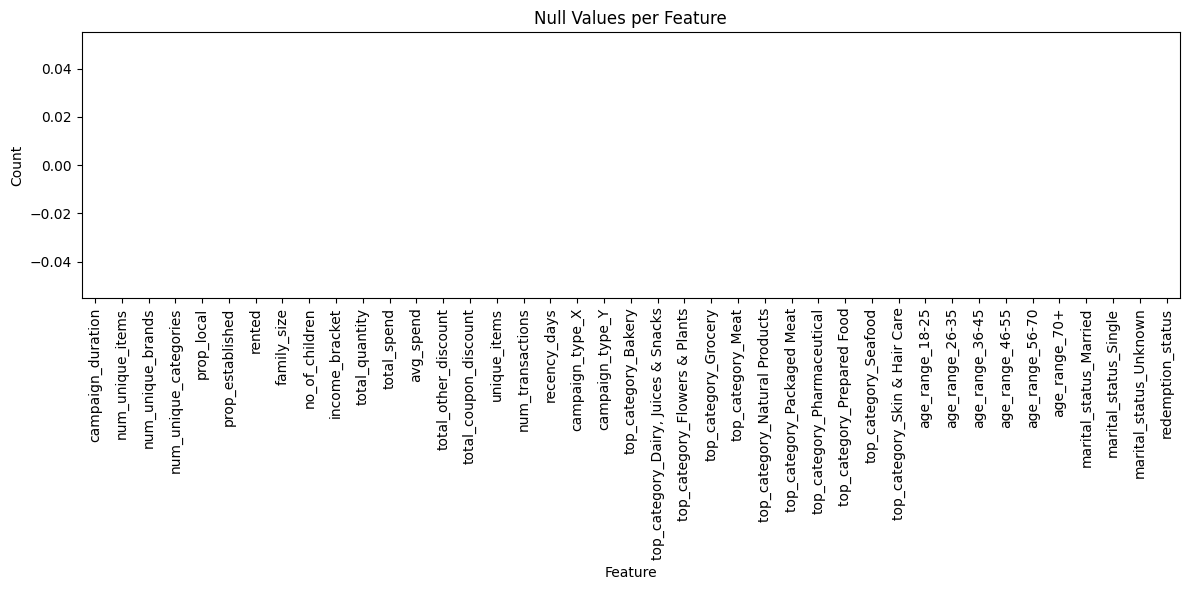

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

null_counts = df.isnull().sum()
plt.figure(figsize=(12, 6))
sns.barplot(x=null_counts.index, y=null_counts.values)
plt.xticks(rotation=90)
plt.title("Null Values per Feature")
plt.ylabel("Count")
plt.xlabel("Feature")
plt.tight_layout()
plt.show()

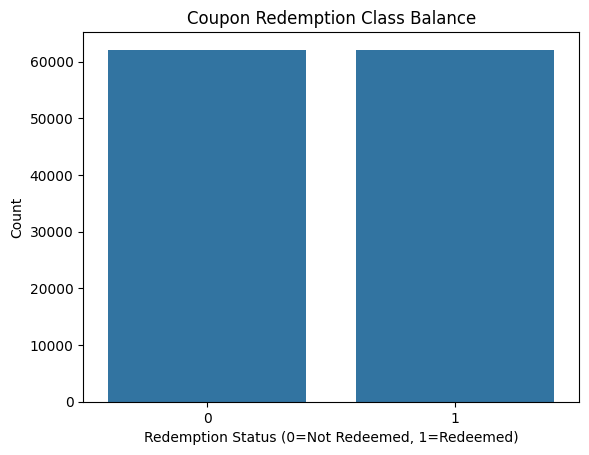

In [28]:
sns.countplot(x="redemption_status", data=df)
plt.title("Coupon Redemption Class Balance")
plt.xlabel("Redemption Status (0=Not Redeemed, 1=Redeemed)")
plt.ylabel("Count")
plt.show()

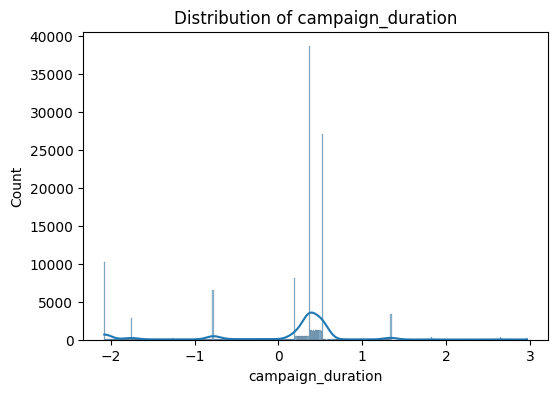

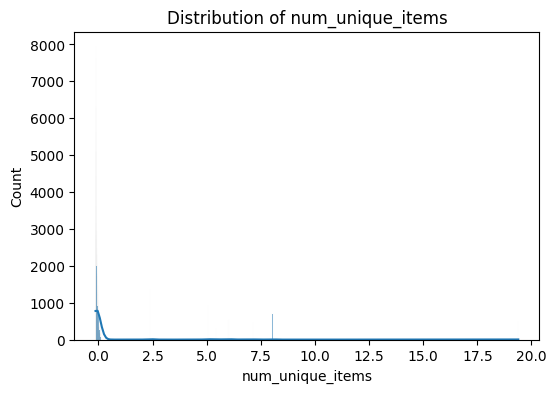

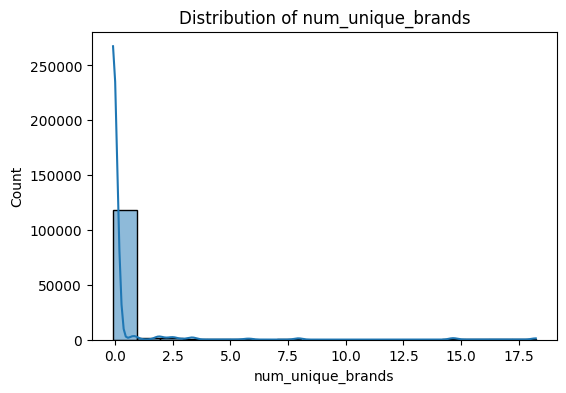

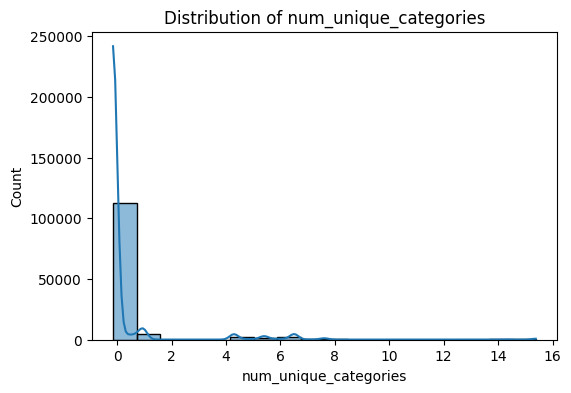

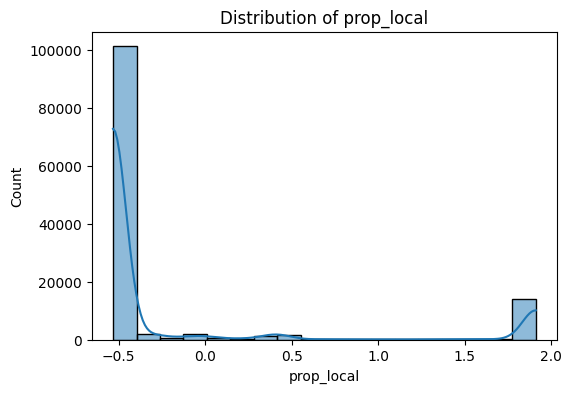

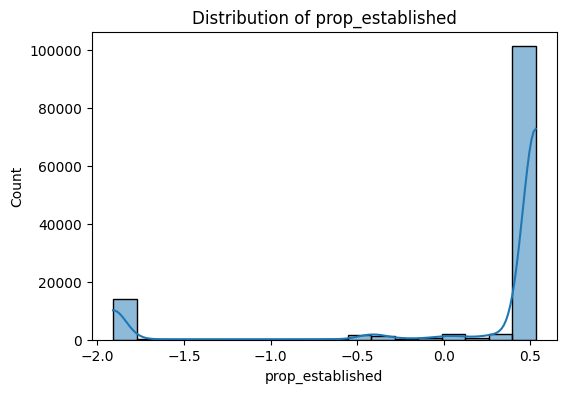

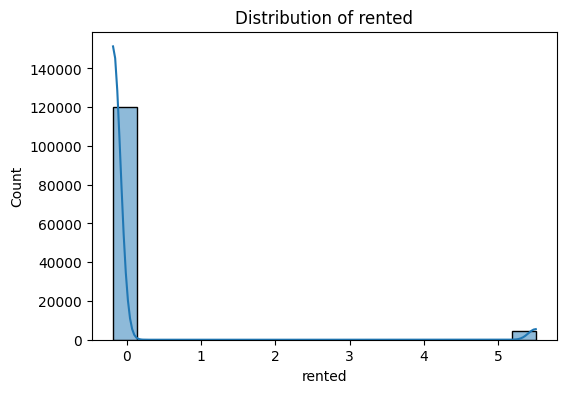

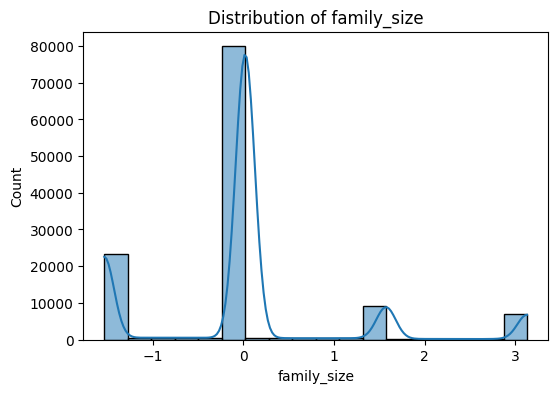

In [29]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_cols.remove('redemption_status')

for col in numeric_cols[:8]:  # Show first 8 numerics
    plt.figure(figsize=(6, 4))
    sns.histplot(df[col], kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()

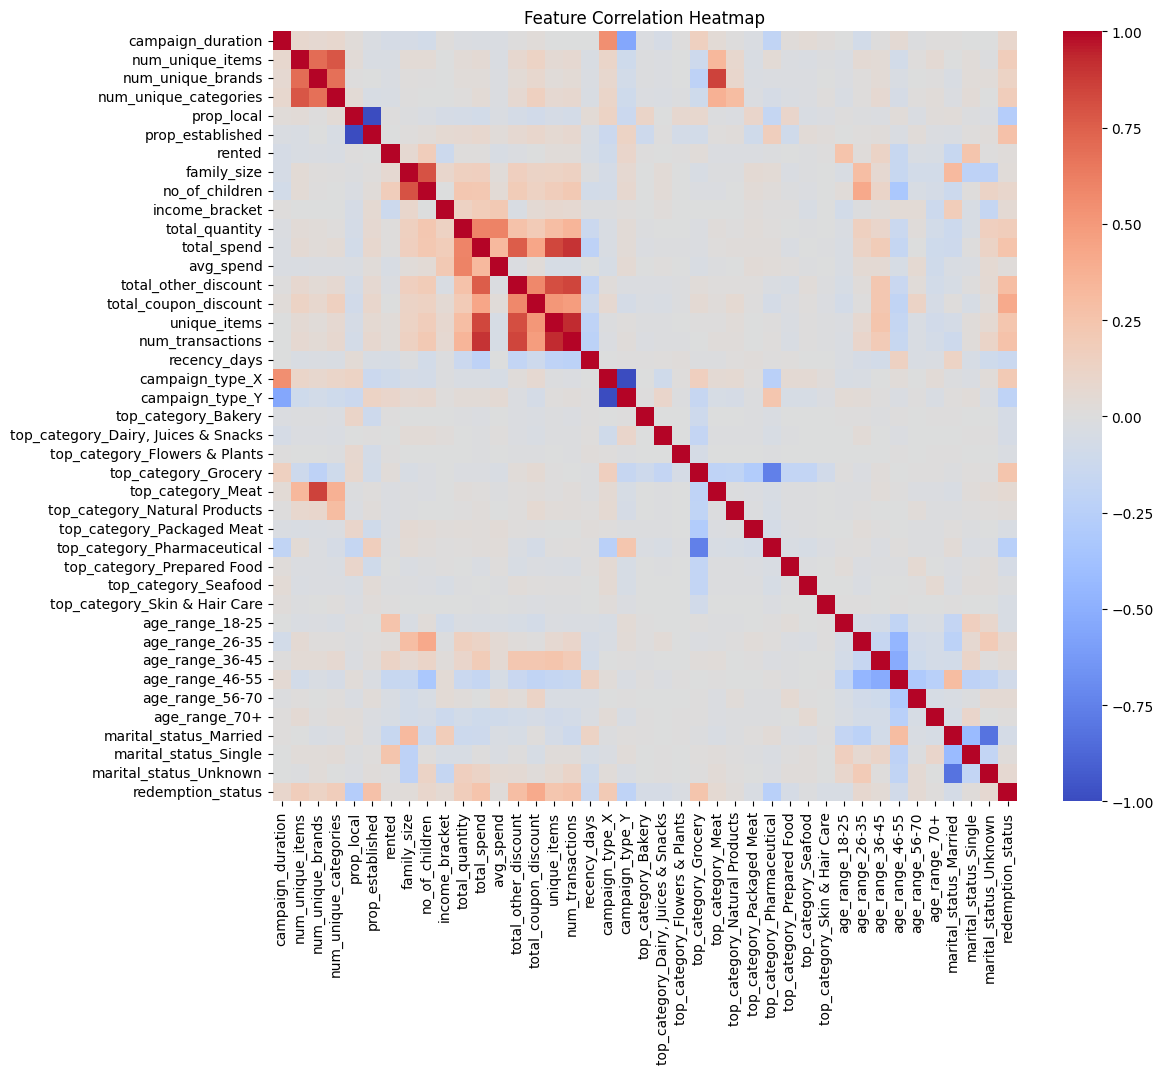

In [30]:
plt.figure(figsize=(12, 10))
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm', annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()

**Random Forest**

In [31]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_auc_score

# ---------------- CONFIG ----------------
TRAIN_PATH = "train_balanced.csv"
VAL_PATH   = "val_balanced.csv"
THRESH_SEARCH = np.linspace(0.05, 0.95, 19)

In [32]:
# ---------------- LOAD DATA ----------------
def load_xy(path):
    df = pd.read_csv(path)
    if 'redemption_status' not in df.columns:
        raise ValueError("redemption_status missing in " + path)
    X = df.drop(columns=['redemption_status']).values.astype(np.float32)
    y = df['redemption_status'].values.astype(np.int64)
    return X, y

X_train, y_train = load_xy(TRAIN_PATH)
X_val, y_val = load_xy(VAL_PATH)

print("Loaded shapes - train:", X_train.shape, "val:", X_val.shape)

Loaded shapes - train: (124224, 40) val: (31056, 40)


In [52]:
# ---------------- RANDOM FOREST ----------------
print("\n------ Random Forest ------")
rf = RandomForestClassifier(
    n_estimators=20,         # fewer trees
    max_depth=3,             # shallow trees
    min_samples_leaf=10,     # more samples per leaf
    min_samples_split=10,    # more samples to split
    random_state=42,
    class_weight=None,
    n_jobs=-1
)
rf.fit(X_train, y_train)

val_rf_probs = rf.predict_proba(X_val)[:, 1]

# Threshold tuning for macro F1
best_rf_thresh = 0.5
best_rf_macro_f1 = -1.0
for t in THRESH_SEARCH:
    preds = (val_rf_probs > t).astype(int)
    m = f1_score(y_val, preds, average='macro')
    if m > best_rf_macro_f1:
        best_rf_macro_f1 = m
        best_rf_thresh = t

print(f"Best RF threshold (macro-F1): {best_rf_thresh:.3f} with macro F1 = {best_rf_macro_f1:.4f}")

rf_val_preds = (val_rf_probs > best_rf_thresh).astype(int)
print("\nRandom Forest Validation classification report (tuned threshold):")
print(classification_report(y_val, rf_val_preds, digits=4, zero_division=0))
print("Random Forest ROC AUC:", roc_auc_score(y_val, val_rf_probs))


------ Random Forest ------
Best RF threshold (macro-F1): 0.550 with macro F1 = 0.8845

Random Forest Validation classification report (tuned threshold):
              precision    recall  f1-score   support

           0     0.8881    0.8800    0.8840     15528
           1     0.8810    0.8891    0.8851     15528

    accuracy                         0.8845     31056
   macro avg     0.8846    0.8845    0.8845     31056
weighted avg     0.8846    0.8845    0.8845     31056

Random Forest ROC AUC: 0.9481648161430676


In [53]:
# ---------------- XGBOOST ----------------
print("\n------ XGBoost ------")
xgb = XGBClassifier(
    n_estimators=20,          # fewer boosting rounds
    max_depth=3,              # shallow trees
    min_child_weight=10,      # minimum sum of instance weight needed in a child
    subsample=0.7,            # less data per tree
    colsample_bytree=0.7,     # fewer features per tree
    reg_alpha=1.0,            # L1 regularization
    reg_lambda=1.0,           # L2 regularization
    learning_rate=0.1,        # slightly higher learning rate
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)
xgb.fit(X_train, y_train)

val_xgb_probs = xgb.predict_proba(X_val)[:, 1]

# Threshold tuning for macro F1
best_xgb_thresh = 0.5
best_xgb_macro_f1 = -1.0
for t in THRESH_SEARCH:
    preds = (val_xgb_probs > t).astype(int)
    m = f1_score(y_val, preds, average='macro')
    if m > best_xgb_macro_f1:
        best_xgb_macro_f1 = m
        best_xgb_thresh = t

print(f"Best XGB threshold (macro-F1): {best_xgb_thresh:.3f} with macro F1 = {best_xgb_macro_f1:.4f}")

xgb_val_preds = (val_xgb_probs > best_xgb_thresh).astype(int)
print("\nXGBoost Validation classification report (tuned threshold):")
print(classification_report(y_val, xgb_val_preds, digits=4, zero_division=0))
print("XGBoost ROC AUC:", roc_auc_score(y_val, val_xgb_probs))


------ XGBoost ------


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [06:23:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best XGB threshold (macro-F1): 0.600 with macro F1 = 0.9075

XGBoost Validation classification report (tuned threshold):
              precision    recall  f1-score   support

           0     0.9090    0.9057    0.9073     15528
           1     0.9060    0.9093    0.9077     15528

    accuracy                         0.9075     31056
   macro avg     0.9075    0.9075    0.9075     31056
weighted avg     0.9075    0.9075    0.9075     31056

XGBoost ROC AUC: 0.9655684270537794


In [54]:
# ---------------- SUMMARY ----------------
print("\nSummary Table (Macro F1, ROC AUC):")
print(f"Random Forest - Macro F1: {best_rf_macro_f1:.4f}, ROC AUC: {roc_auc_score(y_val, val_rf_probs):.4f}")
print(f"XGBoost       - Macro F1: {best_xgb_macro_f1:.4f}, ROC AUC: {roc_auc_score(y_val, val_xgb_probs):.4f}")


Summary Table (Macro F1, ROC AUC):
Random Forest - Macro F1: 0.8845, ROC AUC: 0.9482
XGBoost       - Macro F1: 0.9075, ROC AUC: 0.9656


In [55]:
import pandas as pd
# Load processed test features
df_test = pd.read_csv("test_features_processed.csv")
if 'id' in df_test.columns:
    test_ids = df_test['id'].values
    X_test = df_test.drop(columns=['id']).values.astype(np.float32)
else:
    test_ids = np.arange(len(df_test))
    X_test = df_test.values.astype(np.float32)

# Predict probabilities
rf_test_probs = rf.predict_proba(X_test)[:, 1]
rf_test_preds = (rf_test_probs > best_rf_thresh).astype(int)

xgb_test_probs = xgb.predict_proba(X_test)[:, 1]
xgb_test_preds = (xgb_test_probs > best_xgb_thresh).astype(int)

# Save predictions
rf_submission = pd.DataFrame({"id": test_ids, "redemption_status": rf_test_preds})
rf_submission.to_csv("rf_submission.csv", index=False)
xgb_submission = pd.DataFrame({"id": test_ids, "redemption_status": xgb_test_preds})
xgb_submission.to_csv("xgb_submission.csv", index=False)

In [56]:
rf_submission

,id,redemption_status
0,3,1
1,4,0
2,5,1
3,8,0
4,10,0
...,...,...
50221,128584,0
50222,128588,1
50223,128591,1
50224,128593,1


In [57]:
xgb_submission

,id,redemption_status
0,3,1
1,4,0
2,5,1
3,8,0
4,10,0
...,...,...
50221,128584,0
50222,128588,1
50223,128591,1
50224,128593,1


In [59]:
# Load validation set
val_df = pd.read_csv("val_balanced.csv")
X_val = val_df.drop(columns=['redemption_status']).values.astype(np.float32)
y_val = val_df['redemption_status'].values.astype(int)

# Select one sample (e.g., first row)
sample_X = X_val[40].reshape(1, -1)
sample_true = y_val[0]

# Predict probability and label
rf_sample_prob = rf.predict_proba(sample_X)[0, 1]
rf_sample_pred = int(rf_sample_prob > best_rf_thresh)

print(f"Random Forest Prediction: {'REDEEMED' if rf_sample_pred==1 else 'NOT REDEEMED'} (True label: {sample_true})")
print(f"Probability of redemption: {rf_sample_prob:.4f}")

Random Forest Prediction: NOT REDEEMED (True label: 0)
Probability of redemption: 0.1092


In [58]:
xgb_sample_prob = xgb.predict_proba(sample_X)[0, 1]
xgb_sample_pred = int(xgb_sample_prob > best_xgb_thresh)
print(f"XGBoost Prediction: {'REDEEMED' if xgb_sample_pred==1 else 'NOT REDEEMED'} (True label: {sample_true})")
print(f"Probability of redemption: {xgb_sample_prob:.4f}")

XGBoost Prediction: NOT REDEEMED (True label: 0)
Probability of redemption: 0.0746


In [46]:
import joblib


# Save using joblib (recommended for sklearn/xgboost)
joblib.dump(xgb, "xgb_model.pkl")

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [06:10:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


['xgb_model.pkl']

<Figure size 600x500 with 0 Axes>

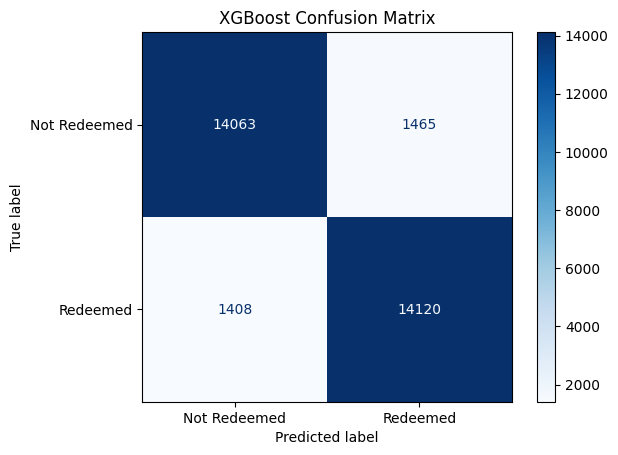

In [60]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Assuming you have y_val (true labels) and xgb_val_preds (predicted labels)
cm = confusion_matrix(y_val, xgb_val_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Redeemed", "Redeemed"])

plt.figure(figsize=(6,5))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("XGBoost Confusion Matrix")
plt.show()

In [61]:
pip install shap

***XAI***

In [62]:
import shap
import matplotlib.pyplot as plt

In [63]:
# Use a small subset if your data is very large for speed!
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_val)

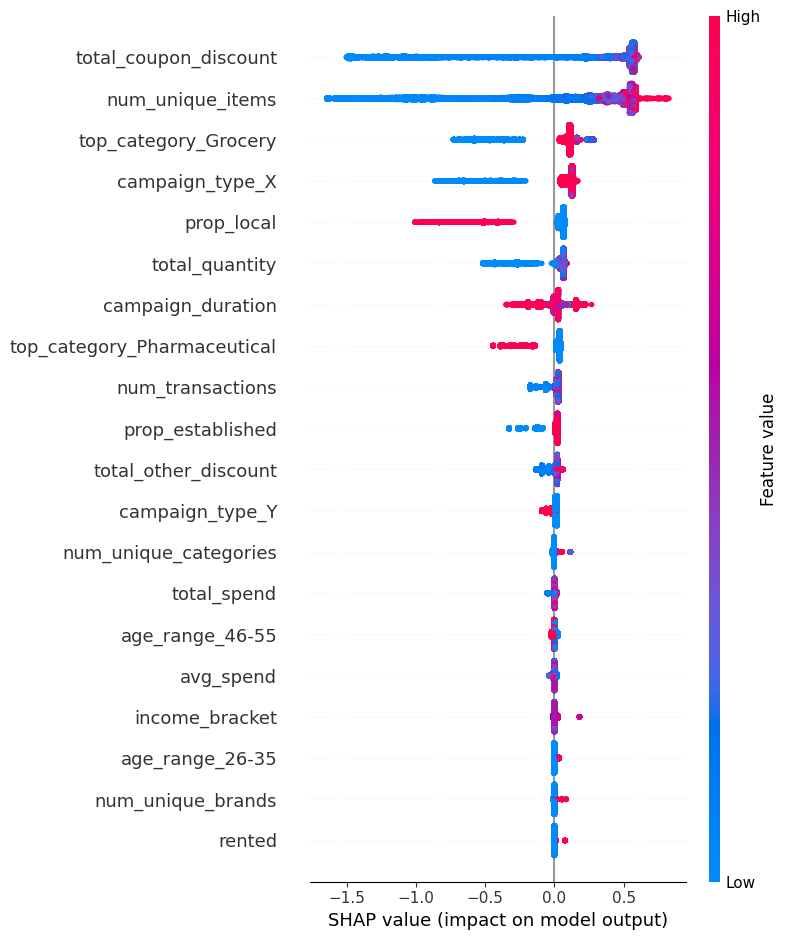

In [64]:
# Summary plot (global feature importance)
plt.figure()
shap.summary_plot(shap_values, X_val, feature_names=val_df.drop(columns=['redemption_status']).columns)
plt.show()

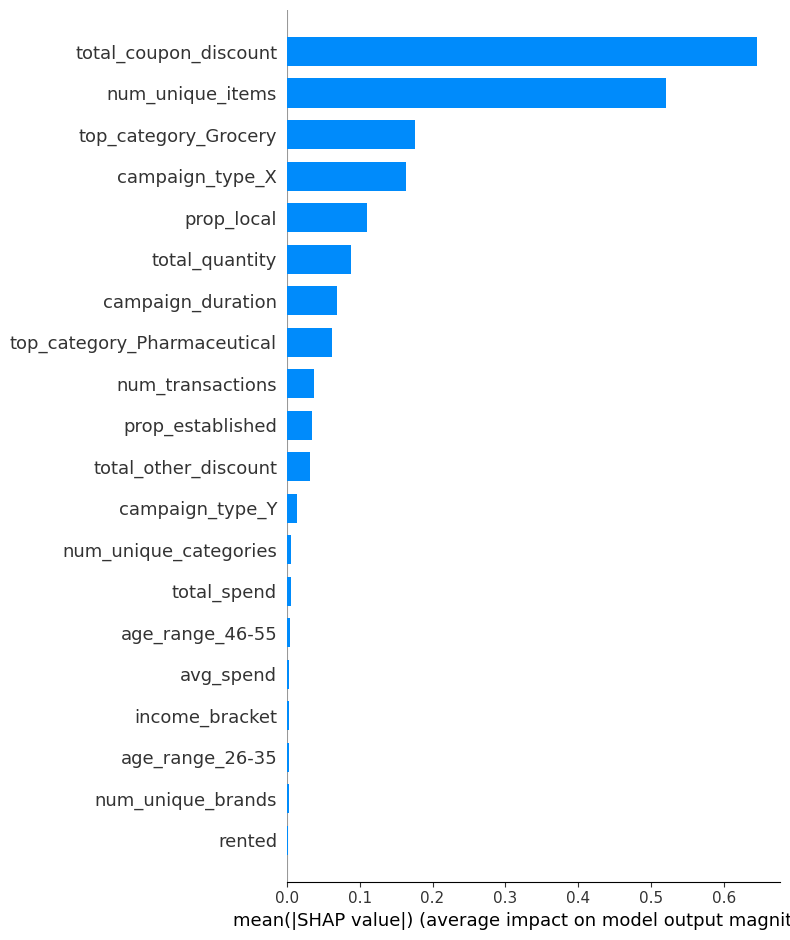

In [65]:
# Bar plot (mean absolute SHAP values per feature)
plt.figure()
shap.summary_plot(shap_values, X_val, feature_names=val_df.drop(columns=['redemption_status']).columns, plot_type="bar")
plt.show()

In [66]:
# Force plot for a single prediction (first validation sample)
sample_index = 0
shap.initjs()
force_plot = shap.force_plot(
    explainer.expected_value,
    shap_values[sample_index],
    X_val[sample_index,:],
    feature_names=val_df.drop(columns=['redemption_status']).columns
)
shap.save_html("xgb_force_plot.html", force_plot)
print("Force plot saved as xgb_force_plot.html")

Force plot saved as xgb_force_plot.html


**Neural Network**

In [67]:
import os, time
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_auc_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import joblib

In [68]:
# ---------------- CONFIG ----------------
TRAIN_PATH = "train_balanced.csv"
VAL_PATH   = "val_balanced.csv"
TEST_PATH  = "test_features_processed.csv"
MODEL_OUT  = "coupon_nn_improved_fixed.pth"
SUB_OUT    = "submission_nn_improved_fixed.csv"

In [69]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

BATCH_SIZE = 256
LR = 1e-3
WEIGHT_DECAY = 1e-5
EPOCHS = 80
PATIENCE = 10
PRINT_EVERY = 1

USE_FOCAL = True           # recommended: True
USE_BCE_WITH_LOGITS = False # set True if you want logits + BCEWithLogitsLoss
THRESH_SEARCH = np.linspace(0.05, 0.95, 19)

In [70]:
# ---------------- UTILS ----------------
def load_xy(path):
    df = pd.read_csv(path)
    if 'redemption_status' not in df.columns:
        raise ValueError("redemption_status missing in " + path)
    X = df.drop(columns=['redemption_status']).values.astype(np.float32)
    y = df['redemption_status'].values.astype(np.int64)
    return X, y

def load_test(path):
    df = pd.read_csv(path)
    if 'id' in df.columns:
        ids = df['id'].values
        X = df.drop(columns=['id']).values.astype(np.float32)
    else:
        ids = np.arange(len(df))
        X = df.values.astype(np.float32)
    return X, ids

In [71]:
# ---------------- FOCAL LOSS ----------------
class FocalLoss(nn.Module):
    # for binary classification - inputs are probs (0..1) when logits=False
    def __init__(self, alpha=0.25, gamma=2.0, logits=False, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduction = reduction

    def forward(self, inputs, targets):
        # inputs: (N,1) floats. targets: (N,1) floats 0/1
        targets = targets.view(-1,1)
        if self.logits:
            # use BCE with logits
            bce_loss = nn.functional.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
            probs = torch.sigmoid(inputs)
        else:
            bce_loss = nn.functional.binary_cross_entropy(inputs, targets, reduction='none')
            probs = inputs
        p_t = probs * targets + (1 - probs) * (1 - targets)
        alpha_factor = self.alpha * targets + (1 - self.alpha) * (1 - targets)
        modulating_factor = (1.0 - p_t) ** self.gamma
        loss = alpha_factor * modulating_factor * bce_loss
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        return loss

In [72]:
# ---------------- MODEL ----------------
class CouponNN(nn.Module):
    def __init__(self, input_dim, use_logits=False):
        super().__init__()
        self.use_logits = use_logits
        self.net = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.40),

            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.35),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.25),

            nn.Linear(256, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.15),

            nn.Linear(64, 1)
        )
    def forward(self, x):
        out = self.net(x)
        if self.use_logits:
            return out  # logits
        return torch.sigmoid(out)  # probabilities


In [73]:
# ---------------- LOAD DATA ----------------
print("Loading train/val/test CSVs...")
X_train, y_train = load_xy(TRAIN_PATH)
X_val, y_val = load_xy(VAL_PATH)
X_test, test_ids = load_test(TEST_PATH)

print("Shapes:", X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape)


Loading train/val/test CSVs...
Shapes: (124224, 40) (124224,) (31056, 40) (31056,) (50226, 40)


In [74]:
# Convert to tensors & dataloaders
train_ds = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train).float().view(-1,1))
val_ds = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val).float().view(-1,1))
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

# ---------------- MODEL + LOSS + OPT ----------------
model = CouponNN(input_dim=X_train.shape[1], use_logits=USE_BCE_WITH_LOGITS).to(DEVICE)

if USE_FOCAL:
    criterion = FocalLoss(alpha=0.25, gamma=2.0, logits=USE_BCE_WITH_LOGITS)
else:
    if USE_BCE_WITH_LOGITS:
        # pos_weight option can be used, but we've balanced data — keep default
        criterion = nn.BCEWithLogitsLoss()
    else:
        criterion = nn.BCELoss()

optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)


In [75]:
# ---------------- TRAIN LOOP with early stopping ----------------
best_val_loss = 1e9
patience = 0
best_epoch = -1
start_time = time.time()

for epoch in range(1, EPOCHS+1):
    model.train()
    train_loss = 0.0
    for xb, yb in train_loader:
        xb = xb.to(DEVICE).float()
        yb = yb.to(DEVICE).float()
        optimizer.zero_grad()
        out = model(xb)
        # Ensure shapes and loss function compatibility
        if USE_BCE_WITH_LOGITS:
            loss = criterion(out.view(-1,1), yb)
        else:
            loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * xb.size(0)
    train_loss = train_loss / len(train_loader.dataset)

    # validation
    model.eval()
    val_loss = 0.0
    val_probs = []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(DEVICE).float()
            yb = yb.to(DEVICE).float()
            out = model(xb)
            if USE_BCE_WITH_LOGITS:
                loss = criterion(out.view(-1,1), yb)
                probs = torch.sigmoid(out).cpu().numpy().flatten()
            else:
                loss = criterion(out, yb)
                probs = out.cpu().numpy().flatten()
            val_loss += loss.item() * xb.size(0)
            val_probs.append(probs)
    val_loss = val_loss / len(val_loader.dataset)
    val_probs = np.concatenate(val_probs)

    # scheduler step + print if LR changed
    old_lr = optimizer.param_groups[0]['lr']
    scheduler.step(val_loss)
    new_lr = optimizer.param_groups[0]['lr']
    if new_lr != old_lr:
        print(f" LR reduced from {old_lr:.6f} → {new_lr:.6f}")

    print(f"Epoch {epoch:03d} | Train Loss: {train_loss:.5f} | Val Loss: {val_loss:.5f}")

    # early stopping
    if val_loss < best_val_loss - 1e-6:
        best_val_loss = val_loss
        best_epoch = epoch
        patience = 0
        torch.save(model.state_dict(), MODEL_OUT + ".tmp")
    else:
        patience += 1
        if patience >= PATIENCE:
            print(f"Early stopping at epoch {epoch}. Best epoch was {best_epoch}")
            break


Epoch 001 | Train Loss: 0.03507 | Val Loss: 0.03998
Epoch 002 | Train Loss: 0.02634 | Val Loss: 0.04576
Epoch 003 | Train Loss: 0.02290 | Val Loss: 0.04398
Epoch 004 | Train Loss: 0.02096 | Val Loss: 0.05003
 LR reduced from 0.001000 → 0.000500
Epoch 005 | Train Loss: 0.01949 | Val Loss: 0.04948
Epoch 006 | Train Loss: 0.01727 | Val Loss: 0.05846
Epoch 007 | Train Loss: 0.01669 | Val Loss: 0.06261
Epoch 008 | Train Loss: 0.01601 | Val Loss: 0.06050
 LR reduced from 0.000500 → 0.000250
Epoch 009 | Train Loss: 0.01567 | Val Loss: 0.05889
Epoch 010 | Train Loss: 0.01448 | Val Loss: 0.06358
Epoch 011 | Train Loss: 0.01416 | Val Loss: 0.06880
Early stopping at epoch 11. Best epoch was 1


In [76]:
# load best model if saved
if os.path.exists(MODEL_OUT + ".tmp"):
    model.load_state_dict(torch.load(MODEL_OUT + ".tmp", map_location=DEVICE))
    os.replace(MODEL_OUT + ".tmp", MODEL_OUT)
    print("Loaded best model and saved to", MODEL_OUT)

elapsed = time.time() - start_time
print(f"Training finished in {elapsed/60:.2f} minutes. Best val loss: {best_val_loss:.6f} (epoch {best_epoch})")

Loaded best model and saved to coupon_nn_improved_fixed.pth
Training finished in 13.74 minutes. Best val loss: 0.039976 (epoch 1)


In [77]:
# ---------------- THRESHOLD TUNING on validation (maximize macro F1) ----------------
model.eval()
with torch.no_grad():
    if USE_BCE_WITH_LOGITS:
        val_probs_all = torch.sigmoid(model(torch.from_numpy(X_val).to(DEVICE).float())).cpu().numpy().flatten()
    else:
        val_probs_all = model(torch.from_numpy(X_val).to(DEVICE).float()).cpu().numpy().flatten()

best_thresh = 0.5
best_macro_f1 = -1.0
for t in THRESH_SEARCH:
    preds = (val_probs_all > t).astype(int)
    m = f1_score(y_val, preds, average='macro')
    if m > best_macro_f1:
        best_macro_f1 = m
        best_thresh = t

print(f"Best threshold (macro-F1): {best_thresh:.3f} with macro F1 = {best_macro_f1:.4f}")

# final metrics at best threshold
val_preds = (val_probs_all > best_thresh).astype(int)
print("\nValidation classification report (tuned threshold):")
print(classification_report(y_val, val_preds, digits=4, zero_division=0))
print("ROC AUC:", roc_auc_score(y_val, val_probs_all))

# ---------------- PREDICT TEST & SAVE ----------------
model.eval()
with torch.no_grad():
    if USE_BCE_WITH_LOGITS:
        test_probs = torch.sigmoid(model(torch.from_numpy(X_test).to(DEVICE).float())).cpu().numpy().flatten()
    else:
        test_probs = model(torch.from_numpy(X_test).to(DEVICE).float()).cpu().numpy().flatten()
test_preds = (test_probs > best_thresh).astype(int)

if test_ids is None:
    submission_df = pd.DataFrame({"id": np.arange(len(test_preds)), "redemption_status": test_preds})
else:
    submission_df = pd.DataFrame({"id": test_ids, "redemption_status": test_preds})
submission_df.to_csv(SUB_OUT, index=False)
print("Saved submission:", SUB_OUT)

print("Done.")

Best threshold (macro-F1): 0.350 with macro F1 = 0.8640

Validation classification report (tuned threshold):
              precision    recall  f1-score   support

           0     0.8689    0.8574    0.8631     15528
           1     0.8592    0.8707    0.8649     15528

    accuracy                         0.8640     31056
   macro avg     0.8641    0.8640    0.8640     31056
weighted avg     0.8641    0.8640    0.8640     31056

ROC AUC: 0.9361497422780631
Saved submission: submission_nn_improved_fixed.csv
Done.


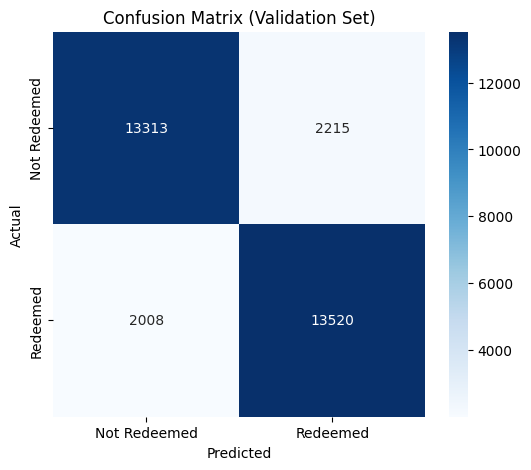

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Use your validation predictions and true labels
# val_preds: predicted labels (0/1)
# y_val: true labels

cm = confusion_matrix(y_val, val_preds)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Redeemed', 'Redeemed'], yticklabels=['Not Redeemed', 'Redeemed'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Validation Set)")
plt.show()

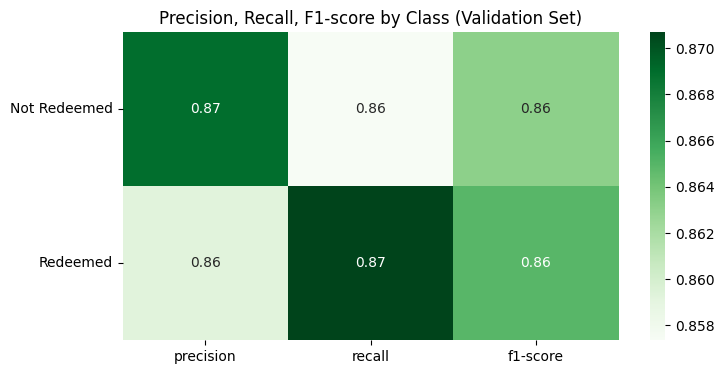

In [80]:
from sklearn.metrics import classification_report

report = classification_report(y_val, val_preds, digits=4, output_dict=True)
report_df = pd.DataFrame(report).transpose()

plt.figure(figsize=(8, 4))
sns.heatmap(report_df.iloc[:2, :3], annot=True, fmt='.2f', cmap='Greens')
plt.title("Precision, Recall, F1-score by Class (Validation Set)")
plt.yticks([0.5, 1.5], ['Not Redeemed', 'Redeemed'], rotation=0)
plt.show()